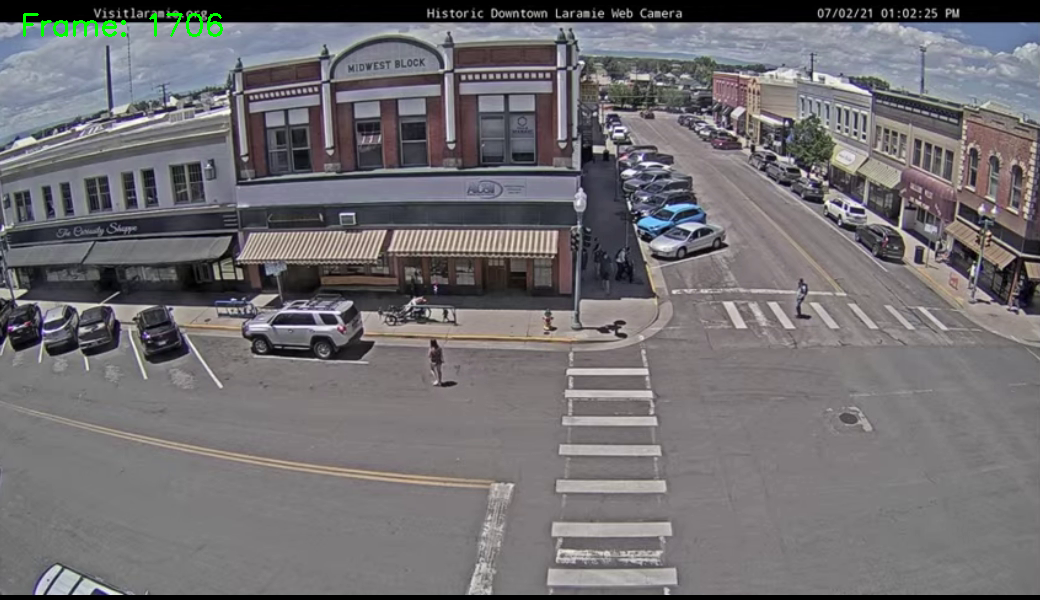

KeyboardInterrupt: 

In [4]:

# Exercise 1.1 - Motion Detection and Tracking (Traffic_Laramie_1.mp4)

## Install required libraries
!pip install opencv-python-headless numpy Pillow

## Import libraries
import cv2
import numpy as np
from IPython.display import display, clear_output
import PIL.Image
import time

# ---- Parameters ----
VIDEO = "Traffic_Laramie_1.mp4"
ROI_FRAC = (0.45, 0.90, 0.10, 0.90)
N_BASELINE = 90
BLUR_K = 21
DIFF_THRESH = 30
MIN_AREA = 1700
ALPHA_SMOOTH = 0.92
WRITE_OUT = True

# ---- Helper Functions ----
def extract_roi(frame):
    h, w = frame.shape[:2]
    y1, y2, x1, x2 = ROI_FRAC
    Y1, Y2, X1, X2 = int(y1*h), int(y2*h), int(x1*w), int(x2*w)
    return frame[Y1:Y2, X1:X2], (Y1, X1)

def to_gray_blur(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.GaussianBlur(g, (BLUR_K, BLUR_K), 0)

# ---- Build Baseline ----
cap = cv2.VideoCapture(VIDEO)
if not cap.isOpened():
    raise RuntimeError(f"Could not open {VIDEO}")

gray_stack = []
while len(gray_stack) < N_BASELINE:
    ok, f = cap.read()
    if not ok:
        break
    roi, _ = extract_roi(f)
    gray_stack.append(to_gray_blur(roi))

if not gray_stack:
    raise RuntimeError("No frames read to build baseline.")

baseline = np.median(np.stack(gray_stack, axis=0), axis=0).astype(np.uint8)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if WRITE_OUT:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(VIDEO.replace(".mp4","_tracked.mp4"), fourcc, fps, (w, h))

# ---- Main Loop ----
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
frame_idx = 0

while True:
    ok, frame = cap.read()
    if not ok:
        break
    frame_idx += 1

    roi, (offY, offX) = extract_roi(frame)
    g = to_gray_blur(roi)

    delta = cv2.absdiff(g, baseline)
    _, mask = cv2.threshold(delta, DIFF_THRESH, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=2)

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        if cv2.contourArea(c) < MIN_AREA:
            continue
        x, y, w2, h2 = cv2.boundingRect(c)
        cv2.rectangle(roi, (x, y), (x + w2, y + h2), (0, 255, 0), 2)

    frame[offY:offY+roi.shape[0], offX:offX+roi.shape[1]] = roi
    cv2.putText(frame, f"Frame: {frame_idx}", (20, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = PIL.Image.fromarray(img_rgb)
    clear_output(wait=True)
    display(img_pil)
    if WRITE_OUT: out.write(frame)
    time.sleep(0.05)

cap.release()
if WRITE_OUT: out.release()
cv2.destroyAllWindows()
print("Finished processing video.")
